# Predicción de la pobreza usando random forest

Usaremos un bosque aleatorio para clasificar hogares entre pobre y no pobre. Se entiende como pobre un hogar cuyos miembros disponen de un ingreso percápita inferior a la línea de pobreza. Usaremos los datos de Colombia para 2024 y un conjunto pequeño de variables predictoras. La LP corresponde a la definición oficial. Esta es una tarea de aprendizaje supervisado

## Datos y librerias

Usamos los datos de la médición de pobreza monetaria para 2024, que se pueden descargar [acá](https://microdatos.dane.gov.co/index.php/catalog/874/data-dictionary/F5?file_name=Personas)

Usaremos las siguientes librerias

In [10]:
# Procesamiento de datos
import pandas as pd
import numpy as np

# Modelación
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Visualización
import matplotlib.pyplot as plt

In [11]:
# Datos de personas
file_p= "C:\\Users\\andre\\OneDrive - Universidad del Norte\\Drive\\Uninorte\\datos pobreza monetaria\\Personas_24.csv"
personas = pd.read_csv(file_p)
print(personas.shape)
# Datos de hogares
file_h="C:\\Users\\andre\\OneDrive - Universidad del Norte\\Drive\\Uninorte\\datos pobreza monetaria\\Hogares_24.csv"
hogares = pd.read_csv(file_h)
print(hogares.shape)

C:\Users\andre\AppData\Local\Temp\ipykernel_14816\3205792540.py:3: DtypeWarning: Columns (130) have mixed types. Specify dtype option on import or set low_memory=False.
  personas = pd.read_csv(file_p)


(784910, 131)
(275057, 21)
(275057, 21)


El análisis se hará a nivel de hogar. Identificamos cada hogar como pobre, 1, o no pobre, 0. Como variables predictoras se usarán la edad, género, nivel educativo, posición ocupacional y estátus laboral del jefe de hogar, además del tamaño del hogar. Usaremos únicamente datos para la la clase cabecera. 

In [12]:
# Seleccionar datos Hogares

columns_to_keep = ['directorio', 'secuencia_p', 'clase','npersug','pobre']
hogares_selected = hogares[columns_to_keep].copy()

# Filtrar por clase: cabecera
hogares_selected = hogares_selected[hogares_selected['clase'] == 1]

# Seleccionar datos Personas
columns_to_keep = ['directorio', 'secuencia_p','clase','p3271','p6040','p6050','p3042','p6430','oc','des','fft']
personas_selected = personas[columns_to_keep].copy()

# Seleccionar jefe de hogar y cabecera
personas_selected = personas_selected[(personas_selected['clase'] == 1) & (personas_selected['p6050'] == 1)]
personas_selected=personas_selected.drop('clase',axis=1)

# Unir Hogares y personas

df=pd.merge(hogares_selected,personas_selected,on=['directorio','secuencia_p'],how='left')
print(df.shape)
df.head()

(237466, 13)


,directorio,secuencia_p,clase,npersug,pobre,p3271,p6040,p6050,p3042,p6430,oc,des,fft
0,7655976,1,1,3,0,1,39,1,5.0,NaN,NaN,NaN,1.0
1,7655977,1,1,2,0,1,39,1,4.0,1.0,1.0,NaN,NaN
2,7655979,1,1,2,0,2,67,1,3.0,NaN,NaN,NaN,1.0
3,7655980,1,1,4,0,1,41,1,4.0,1.0,1.0,NaN,NaN
4,7655981,1,1,4,1,2,48,1,5.0,4.0,1.0,NaN,NaN


In [13]:
# Replace missing values in p6430 based on employment status
print("Before replacing missing values:")
print(f"Missing values in p6430: {df['p6430'].isna().sum()}")

# Check current distribution of employment status variables
print(f"\nDes==1 (unemployed): {(df['des']==1).sum()}")
print(f"Fft==1 (out of labor force): {(df['fft']==1).sum()}")

# Replace missing values based on conditions
# If des==1 (unemployed), replace missing p6430 with 9
df.loc[(df['p6430'].isna()) & (df['des'] == 1), 'p6430'] = 9

# If fft==1 (out of labor force), replace missing p6430 with 10
df.loc[(df['p6430'].isna()) & (df['fft'] == 1), 'p6430'] = 10

print("\nAfter replacing missing values:")
print(f"Missing values in p6430: {df['p6430'].isna().sum()}")

# Show the replacements made
replaced_des = ((df['p6430'] == 9) & (df['des'] == 1)).sum()
replaced_fft = ((df['p6430'] == 10) & (df['fft'] == 1)).sum()

print(f"\nReplacements made:")
print(f"Replaced with 9 (unemployed): {replaced_des}")
print(f"Replaced with 10 (out of labor force): {replaced_fft}")

# Show updated frequency table for p6430
print("\nUpdated frequency table for p6430:")
print("="*40)
freq_table = df['p6430'].value_counts().sort_index()
print(freq_table)
print("-" * 20)
print(f"Total: {freq_table.sum():,}")

Before replacing missing values:
Missing values in p6430: 86210

Des==1 (unemployed): 13822
Fft==1 (out of labor force): 72375

After replacing missing values:
Missing values in p6430: 13

Replacements made:
Replaced with 9 (unemployed): 13822
Replaced with 10 (out of labor force): 72375

Updated frequency table for p6430:
p6430
1.0     62596
2.0     10363
3.0      5099
4.0     66535
5.0      4866
6.0       638
7.0      1118
8.0        41
9.0     13822
10.0    72375
Name: count, dtype: int64
--------------------
Total: 237,453


In [14]:
# Rename p6430 to est_lab (estatus laboral)
df = df.rename(columns={'p6430': 'est_lab'})
df=df.drop(['oc','des','fft'],axis=1)

## Bosque aleatorio

Preprocesamos y partimos los datos en muestra de entrenamiento y prueba

In [15]:
# Drop missing values and prepare data for modeling
print("Before dropping missing values:")
print(f"DataFrame shape: {df.shape}")
print(f"Missing values per column:")
print(df.isnull().sum())

# Drop rows with any missing values
df_clean = df.dropna()

print(f"\nAfter dropping missing values:")
print(f"DataFrame shape: {df_clean.shape}")
print(f"Rows dropped: {len(df) - len(df_clean)}")

Before dropping missing values:
DataFrame shape: (237466, 10)
Missing values per column:
directorio      0
secuencia_p     0
clase           0
npersug         0
pobre           0
p3271           0
p6040           0
p6050           0
p3042           0
est_lab        13
dtype: int64

After dropping missing values:
DataFrame shape: (237453, 10)
Rows dropped: 13


In [16]:
# Define features (X) and target variable (y)
# Features: age, age^2, gender, education, labor status, household size
feature_columns = ['p6040', 'p3271', 'p3042', 'est_lab', 'npersug']  
X = df_clean[feature_columns].copy()

# Create age squared
X['edad_cuadrado'] = X['p6040'] ** 2

# Target variable: poverty status
y = df_clean['pobre'].copy()

# Check target variable distribution
print(f"\nTarget variable distribution:")
print(y.value_counts())
print(f"Poverty rate: {y.mean():.2%}")


Target variable distribution:
pobre
0    173108
1     64345
Name: count, dtype: int64
Poverty rate: 27.10%


In [17]:
# 1. One-hot encoding for categorical non-ordinal variables
# p3271 (gender) and est_lab (labor status)
X_encoded = pd.get_dummies(X, columns=['p3271', 'est_lab'], prefix=['gender', 'lab_status'])

# Encode ordinal variable: p3042 (education level)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X_encoded['education_level'] = label_encoder.fit_transform(X['p3042'])

# Drop the original p3042 column since we have the encoded version
X_encoded = X_encoded.drop('p3042', axis=1)

X_encoded.head()

,p6040,npersug,edad_cuadrado,gender_1,gender_2,lab_status_1.0,lab_status_2.0,lab_status_3.0,lab_status_4.0,lab_status_5.0,lab_status_6.0,lab_status_7.0,lab_status_8.0,lab_status_9.0,lab_status_10.0,education_level
0,39,3,1521,True,False,False,False,False,False,False,False,False,False,False,True,4
1,39,2,1521,True,False,True,False,False,False,False,False,False,False,False,False,3
2,67,2,4489,False,True,False,False,False,False,False,False,False,False,False,True,2
3,41,4,1681,True,False,True,False,False,False,False,False,False,False,False,False,3
4,48,4,2304,False,True,False,False,False,True,False,False,False,False,False,False,4


Para el split aleatorio usamos la opción *stratify* con el propósito de generar una muestra balanceada tanto en entrenamiento como en prueba

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
print(f"Poverty rate train: {y_train.mean():.2%}")
print(f"Poverty rate test: {y_test.mean():.2%}")

Poverty rate train: 27.10%
Poverty rate test: 27.10%


## Ajuste y evaluación del modelo

Primero creamos un bosque aleatorio usando los parámetros de ajuste en los valores por default

**La explicación siguiente fue creada por IA-Claude Sonnet 4**

## ¿Qué es Random Forest?

**Random Forest** es un algoritmo de **aprendizaje ensamblado** que combina múltiples árboles de decisión para crear un modelo más robusto y preciso.

### Conceptos Clave

#### 1. **Ensemble Learning (Aprendizaje Ensamblado)**
- Combina múltiples modelos débiles para crear un modelo fuerte
- **Principio**: "La sabiduría de las multitudes"
- Cada árbol individual puede tener errores, pero el conjunto es más preciso

#### 2. **Bootstrap Aggregating (Bagging)**
- **Bootstrap**: Muestrea con reemplazo del conjunto de entrenamiento
- **Aggregating**: Combina las predicciones de todos los árboles
- Cada árbol se entrena con una muestra diferente del dataset original

#### 3. **Selección Aleatoria de Features**
- En cada división (split) del árbol, solo considera un subconjunto aleatorio de variables
- **Parámetro**: `max_features` (por defecto: √número_de_features)
- Reduce la correlación entre árboles → mejora la generalización

### ¿Cómo funciona Random Forest?

```
Dataset Original (N observaciones, P features)
          ↓
┌─────────────────────────────────────────────────┐
│  PASO 1: Bootstrap Sampling                     │
│  ┌─────────┐  ┌─────────┐  ┌─────────┐         │
│  │ Muestra │  │ Muestra │  │ Muestra │   ...   │
│  │    1    │  │    2    │  │    B    │         │
│  │ (N obs) │  │ (N obs) │  │ (N obs) │         │
│  └─────────┘  └─────────┘  └─────────┘         │
└─────────────────────────────────────────────────┘
          ↓
┌─────────────────────────────────────────────────┐
│  PASO 2: Entrenar Árboles                      │
│  ┌─────────┐  ┌─────────┐  ┌─────────┐         │
│  │ Árbol 1 │  │ Árbol 2 │  │ Árbol B │   ...   │
│  │ (√P     │  │ (√P     │  │ (√P     │         │
│  │features)│  │features)│  │features)│         │
│  └─────────┘  └─────────┘  └─────────┘         │
└─────────────────────────────────────────────────┘
          ↓
┌─────────────────────────────────────────────────┐
│  PASO 3: Aggregation (Votación)                │
│                                                 │
│  Nueva observación → Todos los árboles          │
│  Árbol 1: "Pobre"     (voto: 1)                │
│  Árbol 2: "No Pobre"  (voto: 0)                │
│  Árbol 3: "Pobre"     (voto: 1)                │
│  ...                                            │
│  Árbol B: "Pobre"     (voto: 1)                │
│                                                 │
│  Predicción Final: Clase mayoritaria            │
└─────────────────────────────────────────────────┘
```

### Parámetros Importantes de RandomForestClassifier

#### **Parámetros de Estructura del Bosque:**
- **`n_estimators`** (default=100): Número de árboles en el bosque
  - Más árboles = mejor rendimiento, pero mayor tiempo de cómputo
  - Valores típicos: 50-500

- **`max_features`** (default='sqrt'): Número de features consideradas en cada split
  - `'sqrt'`: √número_de_features (recomendado para clasificación)
  - `'log2'`: log₂(número_de_features)
  - Entero: número específico de features

#### **Parámetros de Control de Árboles:**
- **`max_depth`** (default=None): Profundidad máxima de cada árbol
  - `None` = sin límite (hasta hojas puras)
  - Controla sobreajuste

- **`min_samples_split`** (default=2): Mínimo de muestras para dividir un nodo
- **`min_samples_leaf`** (default=1): Mínimo de muestras en una hoja

#### **Parámetros de Bootstrap:**
- **`bootstrap`** (default=True): Si usar bootstrap sampling
- **`oob_score`** (default=False): Si calcular Out-of-Bag score

#### **Otros Parámetros:**
- **`random_state`**: Para reproducibilidad
- **`n_jobs`**: Paralelización (-1 = usar todos los cores)
- **`class_weight`**: Para datos desbalanceados ('balanced')

### Ventajas y Desventajas de Random Forest

#### **✅ Ventajas:**

1. **Robusto al sobreajuste** - Menos propenso que árboles individuales
2. **Maneja datos faltantes** - Puede trabajar con valores missing
3. **No requiere escalado** - Funciona bien con variables de diferentes escalas
4. **Feature importance** - Proporciona ranking de importancia de variables
5. **Funciona out-of-the-box** - Buenos resultados con parámetros default
6. **Maneja categóricas y numéricas** - Sin necesidad de mucho preprocesamiento
7. **Estimación de error incorporada** - Out-of-Bag (OOB) error
8. **Paralelizable** - Árboles se entrenan independientemente

#### **❌ Desventajas:**

1. **Menos interpretable** - Difícil explicar predicciones individuales
2. **Memoria intensivo** - Almacena múltiples árboles
3. **Puede sobreajustar** - Con datos muy ruidosos
4. **Sesgo hacia variables categóricas** - Con muchas categorías
5. **Predicciones discretas** - No extrapola más allá del rango de entrenamiento

### ¿Por qué funciona Random Forest?

#### **1. Reducción de Varianza**
- Árboles individuales tienen alta varianza (sensibles a cambios en datos)
- Promediar múltiples árboles reduce la varianza total
- **Fórmula**: Var(promedio) = Var(individual)/n + correlación entre árboles

#### **2. Diversidad de Árboles**
- Bootstrap sampling → diferentes datos de entrenamiento
- Random feature selection → diferentes variables en cada split
- Menor correlación entre árboles → mejor rendimiento del ensemble

#### **3. Sabiduría de las Multitudes**
- Errores individuales se cancelan entre sí
- Decisión colectiva más robusta que decisiones individuales

### Random Forest para Clasificación de Pobreza

#### **¿Por qué Random Forest es ideal para predecir pobreza?**

1. **Datos complejos**: Las relaciones entre variables socioeconómicas son no-lineales
   - Edad vs pobreza: relación en U (jóvenes y ancianos más vulnerables)
   - Educación vs pobreza: efectos umbrales (cada nivel educativo tiene impacto diferente)

2. **Variables mixtas**: 
   - Numéricas: edad, tamaño del hogar
   - Categóricas: género, estatus laboral, nivel educativo

3. **Interacciones importantes**:
   - Género × Estatus laboral
   - Edad × Nivel educativo
   - Tamaño hogar × Región

4. **Datos desbalanceados**: Más hogares no pobres que pobres
   - Random Forest maneja bien el desbalance
   - Opción `class_weight='balanced'` para casos extremos

#### **Interpretación de Resultados**

**Feature Importance**: 
- Muestra qué variables son más importantes para predecir pobreza
- Útil para política pública (¿dónde enfocar intervenciones?)

**Out-of-Bag (OOB) Score**:
- Estimación del error sin necesidad de conjunto de validación separado
- Usa las muestras que NO fueron seleccionadas en cada bootstrap

**Predicciones probabilísticas**:
```python
# Probabilidad de ser pobre
proba_poor = rf.predict_proba(X_test)[:, 1]
# Útil para identificar hogares "en riesgo" (probabilidad 0.4-0.6)
```

#### **Configuración recomendada para nuestro problema**:

```python
# Configuración básica (buen punto de partida)
rf_basic = RandomForestClassifier(
    n_estimators=100,    # 100 árboles (balance entre precisión y velocidad)
    random_state=42,     # Reproducibilidad
    n_jobs=-1           # Usar todos los cores disponibles
)

# Configuración avanzada para datos desbalanceados
rf_advanced = RandomForestClassifier(
    n_estimators=200,         # Más árboles para mejor estabilidad
    max_depth=10,            # Limitar profundidad para evitar sobreajuste
    min_samples_split=20,    # Mínimo 20 observaciones para dividir
    min_samples_leaf=10,     # Mínimo 10 observaciones por hoja
    class_weight='balanced', # Balancear clases automáticamente
    oob_score=True,         # Calcular OOB score
    random_state=42,
    n_jobs=-1
)
```

In [19]:
rf=RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluamos las predicciones usando la métrica de *accuracy* que no es otra cosa que el número de predicciones correctas sobre el total de predicciones.

- TP: verdadero positivo
- FP: Falso positivo
- TN: verdadero negativo
- FN: falso negativo

\begin{equation*}
\text{Accuracy}=\dfrac{TP+TN}{TP+TN+FP+FN}
\end{equation*}


In [20]:
y_pred=rf.predict(X_test)

In [21]:
accuracy=accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 76.77%


El *accuracy* parece adecuado, sin embargo, no todo error es igual. A veces los falsos positivos son más graves que los falsos negativos, depende del problema, por eso es importante analizar la matriz de confusión

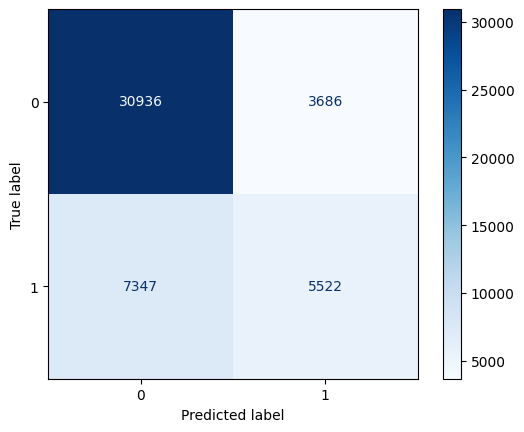

In [22]:
cm=confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)

Con los números de la matriz de confusión podemos construir los indicadores adicionales de sensibilidad, precisión y especificidad

\begin{align*}
\text{Sensibilidad}&=\dfrac{TP}{TP+FN}\\
\text{Precisión}&=\dfrac{TP}{TP+FP}\\
\text{Especificidad}&=\dfrac{TN}{TN+FP}
\end{align*}

| Métrica | Fórmula | Pregunta que responde |
|---------|---------|----------------------|
| **Precision (binary)** | $\frac{TP}{TP + FP}$ | "¿Qué tan confiable es cuando predigo 'pobre'?" |
| **Recall (binary)** | $\frac{TP}{TP + FN}$ | "¿Qué proporción de pobres reales logro detectar?" |
| **Specificity** | $\frac{TN}{TN + FP}$ | "¿Qué proporción de no pobres clasifico correctamente?" |

In [23]:
accuracy=accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")
precision=precision_score(y_test, y_pred, average='binary')
recall=recall_score(y_test, y_pred, average='binary')
specificity=cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"Specificity: {specificity:.2%}")

Accuracy: 76.77%
Precision: 59.97%
Recall: 42.91%
Specificity: 89.35%


Si usamos la opción *average* estamos enfocados en el desempeño del modelo. 

### **Fórmula:**

$$\text{Precision}_{weighted} = \frac{\sum_{i=0}^{n-1} \text{Precision}_i \times n_i}{N}$$

Donde:
- **Precision_i**: Precisión de la clase $i$
- **n_i**: Número de muestras de la clase $i$ en el conjunto de test
- **N**: Número total de muestras ($N = \sum n_i$)

### **Para clasificación binaria (pobre vs no pobre):**

$$\text{Precision}_{weighted} = \frac{\text{Precision}_{no\_pobres} \times n_{no\_pobres} + \text{Precision}_{pobres} \times n_{pobres}}{n_{no\_pobres} + n_{pobres}}$$

In [24]:
accuracy=accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")
precision=precision_score(y_test, y_pred, average='weighted')
recall=recall_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")

Accuracy: 76.77%
Precision: 75.16%
Recall: 76.77%


¿Qué puede concluir después de analizar las métricas de la matriz de confusión? 

## Importancia de variables

**Lo que sigue fue creado con IA-Claude Sonnet 4 y revisado por el profesor**



## ¿Qué es Feature Importance en Random Forest?



**Feature Importance** mide **qué tan importante es cada variable** para hacer predicciones precisas en el modelo Random Forest. Es una de las ventajas clave de este algoritmo.

### **¿Cómo se calcula?**

Random Forest utiliza **Mean Decrease Impurity (MDI)** o **Gini Importance**:

#### **Paso a paso:**

1. **En cada árbol**: Cuando se hace una división (split) en un nodo usando una variable, se mide cuánto **disminuye la impureza**
2. **Acumular por variable**: Se suma todas las disminuciones de impureza que causó cada variable en todos los árboles
3. **Promedio ponderado**: Se pondera por el número de muestras que pasan por cada nodo
4. **Normalizar**: Se divide por el total para que la suma de todas las importancias sea 1.0

### **Fórmula matemática:**

$$\text{Importance}(X_j) = \frac{1}{B} \sum_{b=1}^{B} \sum_{t \in T_b} p(t) \cdot \Delta I(t)$$

Donde:
- **B**: Número de árboles en el bosque
- **T_b**: Conjunto de nodos en el árbol b
- **p(t)**: Proporción de muestras que llegan al nodo t
- **ΔI(t)**: Disminución de impureza en el nodo t al hacer el split con variable X_j

### **Interpretación práctica:**

#### **Valor alto (ej: 0.25)**:
- La variable es **muy importante** para las predicciones
- Aparece frecuentemente en los primeros niveles de los árboles
- Su eliminación degradaría significativamente el modelo

#### **Valor bajo (ej: 0.02)**:
- La variable tiene **poca importancia** para las predicciones
- Aparece raramente o en niveles profundos de los árboles
- Su eliminación tendría poco impacto en el rendimiento

### **¿Qué significa para clasificación de pobreza?**

En nuestro contexto de predicción de pobreza, feature importance nos dice:

- **Variables más discriminantes**: ¿Qué características del jefe de hogar predicen mejor la pobreza?
- **Priorización de políticas**: ¿En qué variables enfocar las intervenciones?
- **Selección de features**: ¿Qué variables podemos eliminar sin perder precisión?

<Axes: >

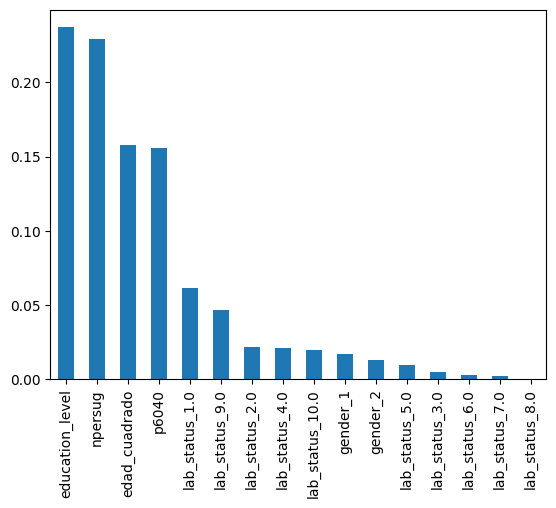

In [25]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot.bar()

### Limitaciones de Feature Importance en Random Forest

#### **⚠️ Cuidados al interpretar:**

1. **Sesgo hacia variables categóricas con muchas categorías**
   - Variables con más categorías (como `est_lab` con múltiples valores) tienden a aparecer como más importantes
   - **Solución**: Considerar el contexto y validar con otros métodos

2. **Correlación entre variables**
   - Si dos variables están correlacionadas, Random Forest puede asignar importancia a cualquiera de las dos
   - **Ejemplo**: Edad y edad² están correlacionadas por construcción

3. **No implica causalidad**
   - Alta importancia ≠ relación causal
   - **Interpretación**: "Variable útil para predicción", no "variable que causa pobreza"

4. **Dependiente de la muestra**
   - Importancias pueden cambiar con diferentes muestras
   - **Recomendación**: Verificar estabilidad con bootstrap o validación cruzada

#### **🔄 Métodos alternativos de feature importance:**

1. **Permutation Importance** (más robusta)
   ```python
   from sklearn.inspection import permutation_importance
   perm_importance = permutation_importance(rf, X_test, y_test)
   ```

2. **SHAP (SHapley Additive exPlanations)**
   ```python
   import shap
   explainer = shap.TreeExplainer(rf)
   shap_values = explainer.shap_values(X_test)
   ```

3. **Drop Column Importance**
   - Entrenar modelo sin cada variable y medir degradación

#### **📋 Mejores prácticas:**

- ✅ Usar feature importance para **exploración inicial**
- ✅ Combinar con **conocimiento del dominio**
- ✅ Validar con **métodos complementarios**
- ✅ Considerar **interacciones entre variables**
- ❌ No tomar decisiones solo basándose en importance
- ❌ No asumir que variables no importantes son inútiles

In [27]:
# Importancia de variables usando random permutation
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.Series(result.importances_mean, index=X_test.columns)

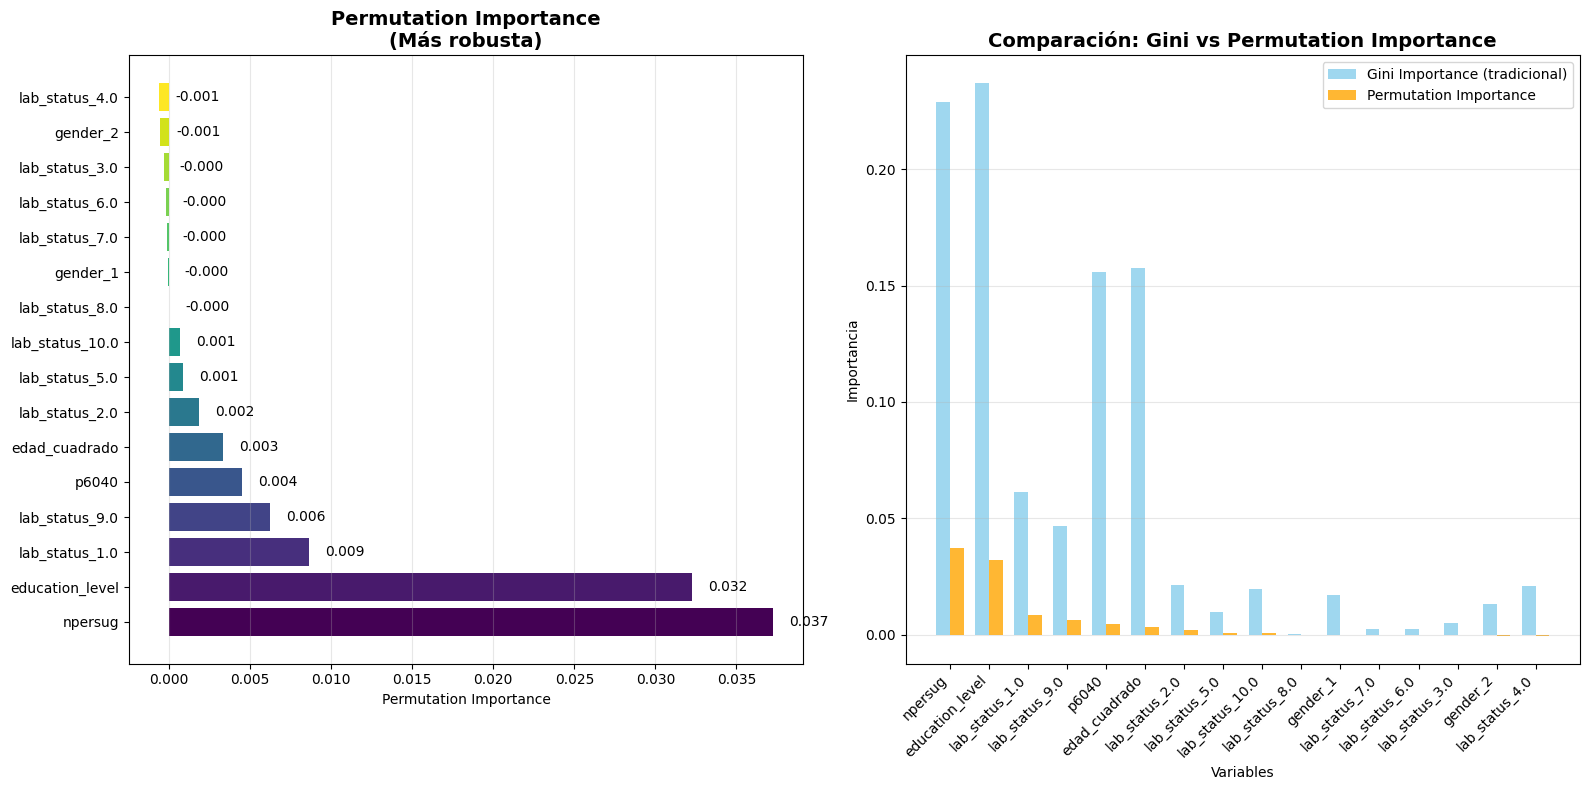

📊 COMPARACIÓN DE MÉTODOS DE FEATURE IMPORTANCE
        feature  gini_importance  rank_gini  perm_importance  rank_perm  rank_diff
        npersug           0.2290        2.0           0.0372        1.0        1.0
education_level           0.2371        1.0           0.0323        2.0        1.0
 lab_status_1.0           0.0612        5.0           0.0086        3.0        2.0
 lab_status_9.0           0.0468        6.0           0.0062        4.0        2.0
          p6040           0.1560        4.0           0.0045        5.0        1.0
  edad_cuadrado           0.1575        3.0           0.0033        6.0        3.0
 lab_status_2.0           0.0215        7.0           0.0018        7.0        0.0
 lab_status_5.0           0.0095       12.0           0.0009        8.0        4.0
lab_status_10.0           0.0197        9.0           0.0007        9.0        0.0
 lab_status_8.0           0.0004       16.0          -0.0000       10.0        6.0
       gender_1           0.0169       1

In [28]:
# Visualizar permutation importance vs feature importance tradicional
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Preparar datos para comparación
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'gini_importance': rf.feature_importances_,
    'perm_importance': perm_importances.values
}).sort_values('perm_importance', ascending=False)

# Gráfico 1: Permutation Importance
colors1 = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
bars1 = ax1.barh(range(len(importance_df)), importance_df['perm_importance'], color=colors1)
ax1.set_yticks(range(len(importance_df)))
ax1.set_yticklabels(importance_df['feature'])
ax1.set_xlabel('Permutation Importance')
ax1.set_title('Permutation Importance\n(Más robusta)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(importance_df['perm_importance']):
    ax1.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=10)

# Gráfico 2: Comparación directa
x_pos = np.arange(len(importance_df))
width = 0.35

bars2 = ax2.bar(x_pos - width/2, importance_df['gini_importance'], width, 
                label='Gini Importance (tradicional)', alpha=0.8, color='skyblue')
bars3 = ax2.bar(x_pos + width/2, importance_df['perm_importance'], width,
                label='Permutation Importance', alpha=0.8, color='orange')

ax2.set_xlabel('Variables')
ax2.set_ylabel('Importancia')
ax2.set_title('Comparación: Gini vs Permutation Importance', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(importance_df['feature'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla comparativa
print("📊 COMPARACIÓN DE MÉTODOS DE FEATURE IMPORTANCE")
print("=" * 60)
comparison_df = importance_df.copy()
comparison_df['rank_gini'] = comparison_df['gini_importance'].rank(ascending=False)
comparison_df['rank_perm'] = comparison_df['perm_importance'].rank(ascending=False)
comparison_df['rank_diff'] = abs(comparison_df['rank_gini'] - comparison_df['rank_perm'])

print(comparison_df[['feature', 'gini_importance', 'rank_gini', 'perm_importance', 'rank_perm', 'rank_diff']]
      .round(4).to_string(index=False))

print(f"\n🔍 ANÁLISIS:")
print("-" * 30)
print(f"Variable más importante (Gini): {comparison_df.loc[comparison_df['gini_importance'].idxmax(), 'feature']}")
print(f"Variable más importante (Permutation): {comparison_df.loc[comparison_df['perm_importance'].idxmax(), 'feature']}")

# Variables con mayor diferencia en ranking
max_diff_idx = comparison_df['rank_diff'].idxmax()
max_diff_var = comparison_df.loc[max_diff_idx, 'feature']
print(f"Mayor diferencia en ranking: {max_diff_var} (diferencia: {comparison_df.loc[max_diff_idx, 'rank_diff']:.0f} posiciones)")

# Correlación entre métodos
correlation = comparison_df['gini_importance'].corr(comparison_df['perm_importance'])
print(f"Correlación entre métodos: {correlation:.3f}")